In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

In [2]:
from finrl.main import check_and_make_directories

In [3]:
#TRAIN_START_DATE = '2015-01-12'
TRAIN_START_DATE = '2015-02-03'
TRAIN_END_DATE = '2020-10-23'
TEST_START_DATE = '2020-10-24'
TEST_END_DATE = '2022-10-24'

START_TIME = "10:00:00"
END_TIME = "14:30:00"
A = 600 #START_TIME in minutes

In [36]:
stock_dimension = 1
state_space = 9
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 9


In [37]:
price = pd.read_csv(r"C:\Users\risha\Files\BIOCON_minute_data_with_indicators.csv")
initial = price.close.loc[0]
price.close -= initial

price['date'] = pd.to_datetime(price['date'])
price["time"] = price['date'].dt.time
price["day"] = price['date'].dt.day
price = price[price['date'].dt.date >= pd.to_datetime(TRAIN_START_DATE).date()]
price = price[price['date'].dt.date <= pd.to_datetime(TEST_END_DATE).date()]

price = price[price["time"] >= pd.to_datetime('10:00:00').time()]
price = price[price["time"] <= pd.to_datetime('15:31:00').time()]
price = price[price['date'].dt.date >= pd.to_datetime(TRAIN_START_DATE).date()]
price = price[price['date'].dt.date <= pd.to_datetime(TEST_END_DATE).date()]

price.reset_index(inplace = True)
price = price[price.index %5 == 0]
price.head()

,index,date,close,high,low,open,volume,sma5,sma10,sma15,...,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA,time,day
0,357,2015-02-03 10:00:00+05:30,-0.20,70.40,70.2,70.40,15093,70.37,70.435,70.433333,...,-3.792186e-14,45.856343,-100.000000,0.106382,0.20,70.266667,20.671098,6.793308e-02,10:00:00,3
5,362,2015-02-03 10:05:00+05:30,-0.10,70.35,70.3,70.30,1368,70.27,70.320,70.380000,...,9.471158e+01,44.860166,-66.666667,0.100614,0.05,70.316667,17.056798,3.153434e-01,10:05:00,3
10,367,2015-02-03 10:10:00+05:30,-0.05,70.35,70.3,70.30,2454,70.28,70.275,70.306667,...,6.666667e+01,38.716866,-33.333333,0.096616,0.05,70.333333,16.446440,-6.082558e-07,10:10:00,3
15,372,2015-02-03 10:15:00+05:30,0.15,70.55,70.4,70.40,5889,70.38,70.330,70.310000,...,7.014401e+01,56.064306,-0.000000,0.101235,0.15,70.500000,17.891549,6.479103e-01,10:15:00,3
20,377,2015-02-03 10:20:00+05:30,0.20,70.65,70.6,70.65,1506,70.60,70.490,70.420000,...,5.609843e+01,70.566502,-11.111111,0.102796,0.05,70.616667,22.141856,1.169270e+00,10:20:00,3


In [42]:
class NewEnv(StockTradingEnv):

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        max_bet: int,
        initial_amount: int,
        buy_cost_pct: float,
        sell_cost_pct: float,
        reward_scaling: float,
        state_space: int,
        action_space: int,
        train: bool = True,
        make_plots: bool = True,
        print_verbosity=10000,
        day=0,
        initial=True,
        previous_state=[],
        model_name="A2C",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        #self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.action_space = spaces.Discrete(self.action_space, start=-1*int(self.action_space/2))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.train = train
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.initial = initial
        self.max_bet = max_bet
        self.previous_state = previous_state
        self.model_name = model_name
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0

        # Instantaneous book positions
        self.cash = self.initial_amount

        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]

        self.rewards_memory = []
        self.actions_memory = []
        self.mtm_change = 0
        self.state_memory = []  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]

        self._seed()

    def _sell_stock(self, action):

        sell_num_shares = 0
        sell_amount = 0
        
        if self.state[1] > 0:
            
            sell_num_shares = min(abs(action), self.state[1])
            sell_amount = (self.data.close * sell_num_shares * (1 - self.sell_cost_pct))

            # update balance
            self.cash += sell_amount
            self.cash = round(self.cash, 2)
            self.state[0] = round(self.state[0] * (1 - sell_num_shares / self.state[1]), 2)

            self.state[1] -= sell_num_shares
            self.cost += (self.data.close * sell_num_shares * self.sell_cost_pct)
            self.cost = round(self.cost, 2)

        return sell_num_shares, sell_amount

    def _buy_stock(self, action):

        available_amount = int(min(self.cash, self.max_bet) / (self.data.close * (1 + self.buy_cost_pct)))  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0

        buy_num_shares = min(available_amount, action)
        buy_num_shares = min(self.hmax-self.state[1],buy_num_shares)
        buy_amount = (self.data.close * buy_num_shares * (1 + self.buy_cost_pct))

        # update balance
        self.cash -= buy_amount
        self.cash = float(round(self.cash, 2))

        self.state[1] += buy_num_shares

        self.cost += (self.data.close * buy_num_shares * self.buy_cost_pct)
        self.cost = round(self.cost, 2)

        return buy_num_shares, buy_amount

    def step(self, actions):

        self.terminal = (self.day >= len(self.df.index.unique()) - 1)

        if self.terminal:
            
            end_total_asset = self.cash + self.data.close * self.state[1]

            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (self.cash + self.data.close * self.state[1] - self.asset_memory[0])  # initial_amount is only cash part of our initial asset

            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["return"] = df_total_value["account_value"].pct_change(1)

            df_changes = df_total_value[df_total_value["return"] != 0]
            
            if df_changes["return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_changes["return"].mean()
                    / df_changes["return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]

            print(f"day: {self.data.date}, episode: {self.episode}")
            print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
            print(f"end_total_asset: {end_total_asset:0.2f}")
            print(f"total_reward: {tot_reward:0.2f}")
            print(f"total_cost: {self.cost:0.2f}")
            print(f"total_trades: {self.trades}")
            if df_total_value["return"].std() != 0:
                print(f"Sharpe: {sharpe:0.3f}")
            print("=================================")

            print("Entered !!")
            df_actions = self.save_action_memory()
            if self.train:
                if self.episode :#% 5 == 0:
                    df_actions.to_csv(
                        "{}/results/account_actions_{}.csv".format(
                            self.model_name,self.iteration
                        )
                    )
                    df_total_value.to_csv(
                        "{}/results/account_value_{}.csv".format(
                            self.model_name,self.iteration
                        ),
                        index=False,
                    )
                    df_rewards.to_csv(
                        "{}/results/account_rewards_{}.csv".format(
                            self.model_name,self.iteration
                        ),
                        index=False,
                    )
                    plt.plot(self.asset_memory, "r")
                    plt.savefig(
                        "{}/results/account_value_{}.png".format(
                            self.model_name,self.episode
                        )
                    )
                    plt.close()
            else:
                df_actions.to_csv(
                    "{}/results/account_actions_test.csv".format(
                        self.model_name
                    )
                )
                df_total_value.to_csv(
                    "{}/results/account_value_test.csv".format(
                        self.model_name
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "{}/results/account_rewards_test.csv".format(
                        self.model_name
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "{}/results/account_value_test.png".format(
                        self.model_name
                    )
                )
                plt.close()

            return self.state, self.reward, self.terminal, False

        else:

            #actions = actions[0]
            actions -= 1

            # if abs(actions) <= 1:
            #     actions = 0
            
            if self.data.time_diff == 1 :
                if int(self.state[1]) > 0:
                    actions = -1
                else:
                    actions = 0
            
            actions = int(actions * self.hmax)
                
            begin_total_asset = self.cash + self.data.close * self.state[1]
            
            if actions < 0:
                num, amount = self._sell_stock(actions)
                num = -1 * num
            elif actions > 0:
                num, amount = self._buy_stock(actions)
            else:
                num, amount = 0, 0

            # Next day
            self.day += 1
            self.data = self.df.loc[self.day, :]
            self.state = self._update_state()
            end_total_asset = self.cash + self.data.close * self.state[1]

            change = 100 * ((end_total_asset - self.asset_memory[0]) / ((self.day) * self.asset_memory[0])) * (self.day > 2000)
            if num > 0:
                self.reward = 2*self.asset_reward() #+ 10*change#+ 0.001 * self.trades * (self.trades < 400)
                self.trades += 1
            elif num < 0:
                self.trades += 1
                self.reward = -1 * self.asset_reward() #+ 10*change#+ 0.001 * self.trades * (self.trades < 400)
            else:
                self.reward = -2 * self.asset_reward() #+ 10*change#+ 0.001 * self.trades * (self.trades < 400)
                
            self.asset_memory.append(end_total_asset)
            self.actions_memory.append(num)
            self.rewards_memory.append(self.reward)
            self.date_memory.append(self._get_date()) # Current timestep already added
            self.state_memory.append(self.state)  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False

    def asset_reward(self):

        weights = [0.4, 0.4, 0.2]
        w = 0
        trade_return = 0
        for idx in range(len(weights)):
            if self.day + (idx + 1) < len(self.df) - 1 and self.df.loc[self.day+idx+1, "time_diff"] > self.data.time_diff:
                trade_return += weights[idx] * (self.df.loc[self.day+idx+1].close - self.data.close) / (self.data.close)
                w += weights[idx]
            else:
                break
        if w == 0:
            return 0
        
        trade_return = trade_return / w
        
        if np.isnan(trade_return):
            return 0
        else:
            return trade_return * 100 

    def reset(self,*,seed=None,options=None,):

        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        self.asset_memory = [self.initial_amount]

        self.cost = 0
        self.trades = 0
        self.daytrades = 0
        self.terminal = False
        self.cash = self.initial_amount

        self.rewards_memory = []
        self.actions_memory = []
        self.mtm_change = 0
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def _initiate_state(self):

        if self.initial:
            state = (
                [0]
                + [0]
                + [self.data.sma10]
                + [self.data.ADX10]
                + [self.data.MOM10]
                + [self.data.PPO]
                + [self.data.RSI8]
                + [self.data.H_L]
                + [self.data.C_O]
            )
            #+ [self.data.upperband]
                #+ [self.data.middleband]
                #+ [self.data.lowerband]
        else:
            # for single stock
            state = (
                [self.previous_state[0]]
                + [self.previous_state[1]]
                + [self.data.sma10]
                + [self.data.ADX10]
                + [self.data.MOM10]
                + [self.data.PPO]
                + [self.data.RSI8]
                + [self.data.H_L]
                + [self.data.C_O]
            )
            #+ [self.data.upperband]
                #+ [self.data.middleband]
                #+ [self.data.lowerband]
        return state

    def _update_state(self):

        if self.day>0:
            prev_close = self.df.loc[self.day-1,'close']
            self.mtm_change = round((self.data.close - prev_close) * self.state[1], 2)

        # for single stock
        state = ([(self.state[0]+self.mtm_change)]
                    + [self.state[1]]
                    + [self.data.sma10]
                    + [self.data.ADX10]
                    + [self.data.MOM10]
                    + [self.data.PPO]
                    + [self.data.RSI8]
                    + [self.data.H_L]
                    + [self.data.C_O])
        #+ [self.data.upperband]
                    #+ [self.data.middleband]
                    #+ [self.data.lowerband]

        return state

    def _get_date(self):
        date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        date_list = self.date_memory[:-1]
        state_list = self.state_memory
        df_states = pd.DataFrame({"date": date_list, "states": state_list})
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"{self.model_name}/results/account_value_trade_{self.episode-1}.png")
        plt.close()

    def render(self, mode="human", close=False):
        return self.state

    def save_action_memory(self):
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        print("Seed :", seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [38]:
def preprocess(address, tic):
    data = pd.read_csv(address)
    data = data[['date', 'close', 'high', 'low', 'open', 'sma10', 'ema10', 'upperband', 'middleband', 'lowerband', 'ADX10', 'APO', 'macd1020', 'MOM10', 'PPO','RSI8']]

    for i in ['sma10']:
        data[i] = (data.close - data[i])

    
    #data = data[data.index % freq == 0]

    data['H_L'] = (data.high - data.low)
    data['H_L'] = data['H_L'].shift(1)
    data['C_O'] = (data.close - data.open)

    for i in ["H_L", "C_O", 'sma10', 'ADX10', 'MOM10', 'PPO','RSI8']:
        data[i] = (data[i] - data[i].rolling(window=5, min_periods=5).mean()) / (data[i].rolling(window=5, min_periods=5).std() + 0.01)

    data['date'] = pd.to_datetime(data['date'])
    data["time"] = data['date'].dt.time
    data["day"] = data['date'].dt.day
    data["tic"] = tic
    data = data[data['date'].dt.date >= pd.to_datetime(TRAIN_START_DATE).date()]
    data = data[data['date'].dt.date <= pd.to_datetime(TEST_END_DATE).date()]

    data = data[data["time"] >= pd.to_datetime('10:00:00').time()]
    data = data[data["time"] <= pd.to_datetime('15:31:00').time()]
    data['time_diff'] = data['time'].apply(lambda t: int(datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()/60 - A))
    data['time_diff'] = data['time_diff'] / 325
    data.drop(["time"], axis = 1, inplace = True)

    data.reset_index(inplace = True)
    data = data[data.index % 5 == 0]

    return data

def split_data(data):
    data = data.copy()
    data = data.dropna()
    train_data = data[data['date'].dt.date <= pd.to_datetime(TRAIN_END_DATE).date()]
    test_data = data[data['date'].dt.date >= pd.to_datetime(TEST_START_DATE).date()]

    train_data.reset_index(inplace = True)
    train_data.drop(["index"], axis = 1, inplace = True)

    test_data.reset_index(inplace = True)
    test_data.drop(["index"], axis = 1, inplace = True)

    return train_data, test_data

train_df = None
test_df = None

for i in ["BIOCON"]:
    address = "Files/"+i+"_minute_data_with_indicators.csv"
    train, test = split_data(preprocess(address, i))
    if train_df is None:
        train_df = train.copy()
        test_df = test.copy()
    else:
        train_df = pd.concat([train_df, train])
        test_df = pd.concat([test_df, test])


train_df = train_df.sort_values(by=["date", "tic"])
train_df.reset_index(inplace = True)
train_df.drop(["index", "open", "high", "low", "day"], axis = 1, inplace = True)

test_df = test_df.sort_values(by=["date", "tic"])
test_df.reset_index(inplace = True)
test_df.drop(["index", "open", "high", "low", "day"], axis = 1, inplace = True)

In [40]:
class DRLAgent_new(DRLAgent):
    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise ValueError(
                f"Model '{model_name}' not found in MODELS."
            )  # this is more informative than NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException as error:
            raise ValueError(f"Failed to load agent. Error: {str(error)}") from error

        # test on the testing env
        state, _ = environment.reset()
        #print(state)
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_amount]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.cash
                + (environment.df.loc[environment.day, "close"] * environment.state[1]).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_amount
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets

In [46]:
buy_cost_list = sell_cost_list = 0.000

from stable_baselines3 import A2C
MODELS = {"a2c" : A2C}

env_kwargs = {
    "hmax": 1,
    "initial_amount": 100000,
    "max_bet": 100000,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "action_space": 3, #stock_dimension,
    "reward_scaling": 1
}
e_trade_gym = NewEnv(df = test_df, model_name = "a2c_test", train = False, **env_kwargs)
env_trade, _ = e_trade_gym.get_sb_env()
agent = DRLAgent_new(env = e_trade_gym)

DATA_SAVE_DIR = e_trade_gym.model_name+"/datasets"
TRAINED_MODEL_DIR = e_trade_gym.model_name+"/trained_models"
TENSORBOARD_LOG_DIR = e_trade_gym.model_name+"/tensorboard_log"
RESULTS_DIR = e_trade_gym.model_name+"/results"

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

results = agent.DRL_prediction_load_from_file("a2c", environment = e_trade_gym, cwd = r"C:\Users\risha\Final Models\A2C2\trained_models.zip", deterministic=True)

Seed : 91994426619729266932366690471961851532
Successfully load model C:\Users\risha\Final Models\A2C2\trained_models.zip
day: 2022-10-21 15:29:00+05:30, episode: 2
begin_total_asset: 100000.00
end_total_asset: 100081.45
total_reward: 81.45
total_cost: 0.00
total_trades: 8143
Sharpe: 0.225
Entered !!
episode_return 1.0008145
Test Finished!


In [117]:
file1 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_value_test - Copy.csv")
val = file1.loc[len(file1)-1, "account_value"]
file2 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_value_test.csv")
file2["account_value"] += (val - 100000)
data = pd.concat([file1, file2], axis = 0)
data['date'] = pd.to_datetime(data['date'])
data["train"] = (data['date'].dt.date <= pd.to_datetime(TRAIN_END_DATE).date()) * 1
data["account_value"] -= 100000

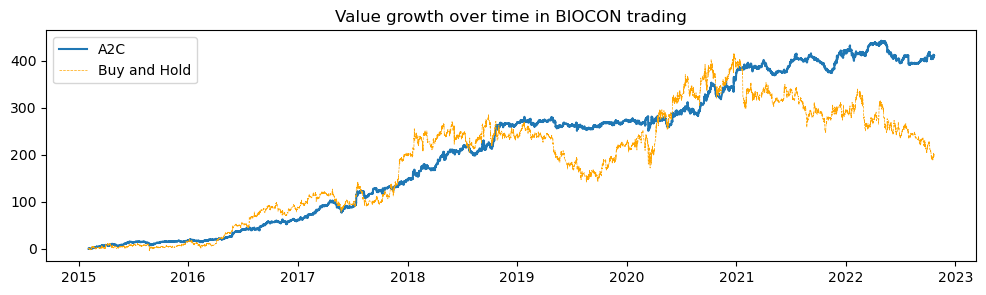

In [48]:
# Set up plot
plt.figure(figsize=(12, 3))

# Plot account value against date
colors = ['blue', 'red']
plt.plot(data['date'], data['account_value'], label = "A2C")
plt.plot(price['date'], price.close, color = "orange", label = "Buy and Hold", linestyle='dashed', linewidth=0.5)

# Set plot labels and title
plt.title('Value growth over time in BIOCON trading')
plt.legend()
plt.savefig("A2C2plot.png")

# Show plot
plt.show()

Seed : 247658011118761371752986988080951456951
Successfully load model C:\Users\risha\Final Models\A2C2\trained_models.zip
day: 2020-10-23 15:25:00+05:30, episode: 2
begin_total_asset: 100000.00
end_total_asset: 101463.40
total_reward: 1463.40
total_cost: 0.00
total_trades: 19494
Sharpe: 0.262
Entered !!
episode_return 1.014634
Test Finished!
Seed : 156172625468208214271833724530581590100
Successfully load model C:\Users\risha\Final Models\A2C2\trained_models.zip
day: 2022-10-21 15:28:00+05:30, episode: 2
begin_total_asset: 100000.00
end_total_asset: 100511.25
total_reward: 511.25
total_cost: 0.00
total_trades: 635
Sharpe: 0.061
Entered !!
episode_return 1.0051125
Test Finished!
Seed : 183415973865815557540129957701222681691
Successfully load model C:\Users\risha\Final Models\A2C2\trained_models.zip
day: 2020-10-23 15:27:00+05:30, episode: 2
begin_total_asset: 100000.00
end_total_asset: 100440.70
total_reward: 440.70
total_cost: 0.00
total_trades: 23083
Sharpe: 0.342
Entered !!
episode

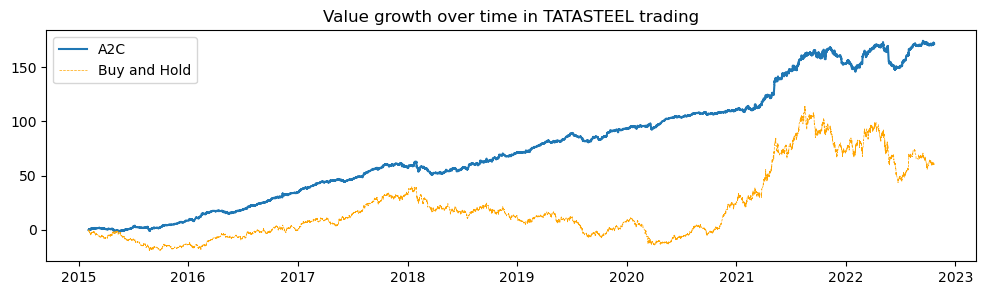

In [52]:
for i in ["RELIANCE", "ADANIPORTS", "AMBUJACEM", "BAJAJHLDNG", "BAJFINANCE", "BHARTIARTL", "BPCL", "CIPLA", "COALINDIA", "DABUR", "DIVISLAB", "GAIL", "HAVELLS", "HCLTECH", "HDFC", "HINDPETRO", "INDUSTOWER", "LT", "MARUTI", "NIFTY BANK", "ONGC", "SAIL", "SBIN", "SUNPHARMA", "TATASTEEL"]:
    train_df = None
    test_df = None
    
    address = "Files/"+i+"_minute_data_with_indicators.csv"
    train, test = split_data(preprocess(address, i))
    if train_df is None:
        train_df = train.copy()
        test_df = test.copy()
    else:
        train_df = pd.concat([train_df, train])
        test_df = pd.concat([test_df, test])
    
    
    train_df = train_df.sort_values(by=["date", "tic"])
    train_df.reset_index(inplace = True)
    train_df.drop(["index", "open", "high", "low", "day"], axis = 1, inplace = True)
    
    test_df = test_df.sort_values(by=["date", "tic"])
    test_df.reset_index(inplace = True)
    test_df.drop(["index", "open", "high", "low", "day"], axis = 1, inplace = True)

    price = pd.read_csv(r"C:\Users\risha\Files\{}_minute_data_with_indicators.csv".format(i))
    initial = price.close.loc[0]
    price.close -= initial
    
    price['date'] = pd.to_datetime(price['date'])
    price["time"] = price['date'].dt.time
    price["day"] = price['date'].dt.day
    price = price[price['date'].dt.date >= pd.to_datetime(TRAIN_START_DATE).date()]
    price = price[price['date'].dt.date <= pd.to_datetime(TEST_END_DATE).date()]
    
    price = price[price["time"] >= pd.to_datetime('10:00:00').time()]
    price = price[price["time"] <= pd.to_datetime('15:31:00').time()]
    price = price[price['date'].dt.date >= pd.to_datetime(TRAIN_START_DATE).date()]
    price = price[price['date'].dt.date <= pd.to_datetime(TEST_END_DATE).date()]

    price.reset_index(inplace = True)
    price = price[price.index %5 == 0]

    ################      TRAINING
    e_trade_gym = NewEnv(df = train_df, model_name = "Plots\{}_test_train".format(i), train = False, **env_kwargs)
    env_trade, _ = e_trade_gym.get_sb_env()
    agent = DRLAgent_new(env = e_trade_gym)

    RESULTS_DIR = e_trade_gym.model_name+"/results"
    
    check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
    
    results = agent.DRL_prediction_load_from_file("a2c", environment = e_trade_gym, cwd = r"C:\Users\risha\Final Models\A2C2\trained_models.zip", deterministic=True)


    ################      TRAINING
    e_trade_gym = NewEnv(df = test_df, model_name = "Plots\{}_test".format(i), train = False, **env_kwargs)
    env_trade, _ = e_trade_gym.get_sb_env()
    agent = DRLAgent_new(env = e_trade_gym)

    RESULTS_DIR = e_trade_gym.model_name+"/results"
    
    check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
    
    results = agent.DRL_prediction_load_from_file("a2c", environment = e_trade_gym, cwd = r"C:\Users\risha\Final Models\A2C2\trained_models.zip", deterministic=True)


    file1 = pd.read_csv(r"C:\Users\risha\Plots\{}_test_train\results\account_value_test.csv".format(i))
    val = file1.loc[len(file1)-1, "account_value"]
    file2 = pd.read_csv(r"C:\Users\risha\Plots\{}_test\results\account_value_test.csv".format(i))
    file2["account_value"] += (val - 100000)
    data = pd.concat([file1, file2], axis = 0)
    data['date'] = pd.to_datetime(data['date'])
    data["train"] = (data['date'].dt.date <= pd.to_datetime(TRAIN_END_DATE).date()) * 1
    data["account_value"] -= 100000

    # Set up plot
    plt.figure(figsize=(12, 3))
    
    # Plot account value against date
    colors = ['blue', 'red']
    plt.plot(data['date'], data['account_value'], label = "A2C")
    plt.plot(price['date'], price.close, color = "orange", label = "Buy and Hold", linestyle='dashed', linewidth=0.5)
    
    # Set plot labels and title
    plt.title('Value growth over time in {} trading'.format(i))
    plt.legend()
    plt.savefig("Images\{}plot.png".format(i))

In [118]:
file1 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_actions_test - Copy.csv")
file2 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_actions_test.csv")
data1 = pd.concat([file1, file2], axis = 0)
data1['date'] = pd.to_datetime(data1['date'])

In [119]:
file1 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_value_test - Copy.csv")
val = file1.loc[len(file1)-1, "account_value"]
file2 = pd.read_csv(r"C:\Users\risha\a2c_test_NIFTY\results\account_value_test.csv")
file2["account_value"] += (val - 100000)
data2 = pd.concat([file1, file2], axis = 0)
data2['date'] = pd.to_datetime(data2['date'])

In [120]:
val

104265.75

In [121]:
data1.head()

,Unnamed: 0,date,actions
0,0,2015-01-12 10:00:00+05:30,0
1,1,2015-01-12 10:05:00+05:30,0
2,2,2015-01-12 10:10:00+05:30,0
3,3,2015-01-12 10:15:00+05:30,0
4,4,2015-01-12 10:20:00+05:30,0


In [122]:
merged_df = pd.merge(data1, data2, on='date')

In [123]:
merged_df

,Unnamed: 0,date,actions,account_value,return
0,0,2015-01-12 10:00:00+05:30,0,100000.00,NaN
1,1,2015-01-12 10:05:00+05:30,0,100000.00,0.0
2,2,2015-01-12 10:10:00+05:30,0,100000.00,0.0
3,3,2015-01-12 10:15:00+05:30,0,100000.00,0.0
4,4,2015-01-12 10:20:00+05:30,0,100000.00,0.0
...,...,...,...,...,...
119706,30686,2022-10-21 15:00:00+05:30,0,106315.75,0.0
119707,30687,2022-10-21 15:05:00+05:30,0,106315.75,0.0
119708,30688,2022-10-21 15:10:00+05:30,0,106315.75,0.0
119709,30689,2022-10-21 15:15:00+05:30,0,106315.75,0.0


In [125]:
returns = []
trades = []
prev_val = None

for idx, row in merged_df.iterrows():  # Iterate over rows properly
    
    if row['actions'] == 1:  # Access columns using row[column_name]
        prev_val = row['account_value']  # Update prev_val
        
    if row['actions'] == -1 and prev_val is not None:  # Check if prev_val is not None
        returns.append(row['account_value'] - prev_val)  # Calculate and append return

In [126]:
ret = np.array(returns)
pos = ret[np.where(ret > 0)]
neg = ret[np.where(ret <= 0)]

In [127]:
len(pos)/len(neg)

0.640551445864156

In [128]:
np.mean(pos)/np.mean(neg)

-1.7664628224628123

In [129]:
merged_df["value"] = -1*merged_df.actions*merged_df.account_value
combined_assets = merged_df.groupby(merged_df['date'].dt.date)['value'].sum().reset_index()

In [132]:
combined_assets.loc[1249, "value"] += combined_assets.loc[124, "value"]
combined_assets.loc[1248, "value"] = np.nan

In [113]:
prev_index = None
prev_value = None
for idx, i in enumerate(combined_assets.value):
    if abs(i) > 100:
        if prev_value is None:
            prev_value = i
            combined_assets.loc[idx, "value"] = np.nan
        else:
            combined_assets.loc[idx, "value"] = i + prev_value
            prev_value = None

In [133]:
np.nanmean(combined_assets.value)

3.4767916207276706

In [134]:
merged_df["abs"] = np.abs(merged_df.actions)

In [137]:
combined = merged_df.groupby(merged_df['date'].dt.date)['abs'].sum().reset_index()

In [141]:
combined.describe()

,abs
count,1815.000000
mean,10.752617
std,4.387886
min,1.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,26.000000


In [144]:
(252**0.5)*np.mean(returns)/np.std(returns)

0.3605703547710676

In [146]:
(1.631575)**(5.5*12*252/119710)-1

0.07038181289285261

In [34]:
index = []
for i in ["BIOCON", "RELIANCE", "ADANIPORTS", "AMBUJACEM", "BAJAJHLDNG", "BAJFINANCE", "BHARTIARTL", "BPCL", "CIPLA", "COALINDIA", "DABUR", "DIVISLAB", "GAIL", "HAVELLS", "HCLTECH", "HDFC", "HINDPETRO", "INDUSTOWER", "LT", "MARUTI", "NIFTY BANK", "ONGC", "SAIL", "SBIN", "SUNPHARMA", "TATASTEEL"]:

    # address = "Files/"+i+"_minute_data_with_indicators.csv"
    # df = pd.read_csv(address)
    # df['date'] = pd.to_datetime(df['date'])
    # df["day"] = df['date'].dt.day
    # df = df[df['date'].dt.date >= pd.to_datetime("2019-01-01").date()]
    # df = df[df['date'].dt.date <= pd.to_datetime("2022-02-02").date()]
    # df = df[df.index%5 == 0]
    # df.reset_index(inplace = True)
    # df["returns"] = np.abs(df.close.pct_change())

    file1 = pd.read_csv(r"C:\Users\risha\Plots\{}_test_train\results\account_value_test.csv".format(i))

    index.append([i, file1.account_value.std()])

In [35]:
d = pd.DataFrame(index)

In [36]:
d.to_csv("index2.csv")

In [37]:
f = pd.read_csv("index.csv")

In [38]:
from mpl_toolkits.mplot3d import Axes3D

In [39]:
f['color_column'] = f['Y'].apply(lambda x: 'blue' if x == 1 else 'red')

In [43]:
f.head()

,Tic,Mean returns,Vol_by_Outstanding,Capitalization,Y,color_column
0,BIOCON,0.001568,0.403443,5.905362,1,blue
1,RELIANCE,0.001300,0.204226,9.885833,1,blue
2,ADANIPORTS,0.001716,0.417725,7.958577,1,blue
3,AMBUJACEM,0.001574,0.270736,2.890372,1,blue
4,BAJAJHLDNG,0.001548,0.058676,6.810142,0,red


In [44]:
d = f[["Vol_by_Outstanding", "Mean returns", "Capitalization", "Y"]]
d.corr()

,Vol_by_Outstanding,Mean returns,Capitalization,Y
Vol_by_Outstanding,1.000000,0.589178,0.100470,0.149701
Mean returns,0.589178,1.000000,-0.060400,0.103596
Capitalization,0.100470,-0.060400,1.000000,-0.094372
Y,0.149701,0.103596,-0.094372,1.000000


C:\Users\risha\AppData\Local\Temp\ipykernel_23488\4213965082.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(f['Vol_by_Outstanding'], f['Capitalization'], c=f['color_column'], cmap='viridis')


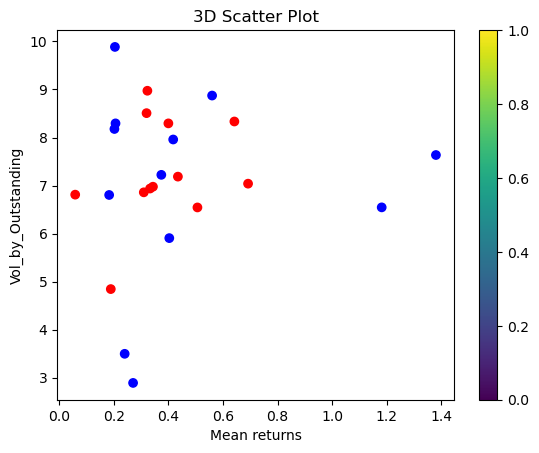

In [41]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)

# Create a scatter plot with color coding
scatter = ax.scatter(f['Vol_by_Outstanding'], f['Capitalization'], c=f['color_column'], cmap='viridis')

# Add labels and title
ax.set_xlabel('Mean returns')
ax.set_ylabel('Vol_by_Outstanding')
#ax.set_zlabel('Capitalization')
ax.set_title('3D Scatter Plot')

# Add a color bar
plt.colorbar(scatter)

# Show the plot
plt.show()